<h1>Language Model Without Smoothing </h1>

In [1]:
import nltk
import os
import string
from nltk.util import ngrams
from math import log
import matplotlib.pyplot as plt
%matplotlib inline

stopwords=['','(',')','{','}','\\','--',':','-',"'s"]
punct=string.punctuation+"``"+"''"+'"'

In [2]:
#nltk.corpus.brown.categories() # give the available brown corpus categories 
#os.listdir(nltk.data.find("corpora"))

<h3> NLTK Brown Corpus </h3>
<p>Function takes catgories as argument and return pre-processed brown corpus text as string.</p>
<p>Inorder to know the available categorise of Brown Corpus type</p><br/>
<code>nltk.corpus.brown.categories()</code>

In [3]:
nltk.corpus.brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [4]:
def nltk_brown_corpus(category='news'):
    sents=[]
    sentences=nltk.corpus.brown.sents(categories=category)
    for sent in sentences:
        sent=" ".join([word.lower() for word in sent if word not in punct and word not in stopwords])
        sents.append(sent)
    text="\n".join(sents)
    return text

In [5]:
def brown_corpus_categories_text():
    text=''
    for category in nltk.corpus.brown.categories():
        text+= nltk_brown_corpus(category=category)
    return text

In [6]:
#nltk.corpus.brown.sents(categories='news')

<p>The Function takes directory containing files or directly file path as first argument i.e repo. 
Second parameter specifies number of file to read from directory if <code>repo</code> is assigned with directory, i.e <code>num_articles</code>.
By default it is set to 100 files.</p>

In [7]:
def read_filename(repo, num_articles=100):
    files=[]
    if os.path.isfile(repo):
        files.append(repo)
    elif os.path.isdir(repo):
        files= [os.path.join(repo, f) for f in os.listdir(repo)[:num_articles] if os.path.isfile(os.path.join(repo, f))]
    else:
        print('Provide correct file/directory information')
        return
    return files  

<p>The Function is written to read files available in directory. It will return an iterator over the 
file contents. </p>

In [8]:
def extract_file_content(filenames):
    for file in filenames:
        with open(file,'r') as fp:
            yield fp.read().lower().replace('\n',' ')

<p>The function <code>create_tokens</code> takes as input a list of filenames or plain text and returns list of sentences.
    The output <code>sents</code> is a list of lists structure <code>[[], [], ....]</code>. </p>
<p>The Input Argument <code> corpus </code> may represent 1) list of filenames or 2) text. 
Each sentence itself is list of words. </p>
<p><code>nltk.sent_tokenize():</code> Return list of sentences from the given file</p>
<p><code>nltk.word_tokenize():</code> Return list of words from the given sentence/file </p>

In [9]:
def create_tokens(corpus):
    sents=[]
    if isinstance(corpus, list):
        for file_content in extract_file_content(corpus):
            for sent in nltk.sent_tokenize(file_content):
                token= [word for word in nltk.word_tokenize(sent) if word not in punct and word not in stopwords]
                sents.append(token)
    elif type(corpus) is str:
        for sent in nltk.sent_tokenize(corpus):
            token= [word for word in nltk.word_tokenize(sent) if word not in punct and word not in stopwords]
            sents.append(token)
    else:
        print('Corpus problem')      
    return sents

<p>Split sentences into training and test set based on <code>ratio</code> parameter. 
By deafult it is set to 99%</p>

In [135]:
def train_test_split(sents, ratio=0.99):
    if len(sents) > 0:
        spl = int(ratio*len(sents))
        train_corpus = sents[:spl]
        test_corpus = sents[spl:]
    else:
        print('Corpus not created')
    train_corpus = [word for sent in train_corpus for word in sent]
    test_corpus = [word for sent in test_corpus for word in sent]
    return train_corpus, test_corpus

In [136]:
def cross_validation(sents, k=5):
    inx=0
    fold_size=int(len(sents)/k)
    for i in range(1, k+1):
        test_sents=sents[inx:inx+fold_size]
        train_sents=sents[0:inx]+sents[inx+fold_size:]
        inx=i*fold_size
        test_sents = [word for sent in test_sents for word in sent]
        train_sents = [word for sent in train_sents for word in sent]
        yield train_sents, test_sents

<p> The Function takes list of words or raw text string as <code>corpus</code>. Based on <code>ngram</code> value 
given it will return frequency distribution of ngrams.</p>
<p><code>nltk.FreqDist:</code> Takes argument as list or list generator and returns dictionary with key as ngrams 
    and value as frequency.</p>
<p><code>nltk.ConditionalFreqDist:</code> Returns dictionary of dictionary(FreqDist) for bigrams. First dictionary 
contains key as context word and dictionary as value. The value dictionary contains word following the context 
word as key and frequency as value. </p>
<p><b>Example:</b><code>FreqDist(word2|word1)=X</code> is represented as <code>{(word1):{(word2):X}}</code></p> 

In [196]:
def ngram_freq_dist(corpus, ngram=1):
    if isinstance(corpus, list) and len(corpus)>0:
        train_corpus=corpus
    elif type(corpus) is str:
        train_corpus=nltk.word_tokenize(corpus)
    else:
        print('Error')
        return None
    
    freq_dist=None
    if ngram==1:
        freq_dist = nltk.FreqDist(train_corpus) #freq distibution for unigrams
    elif ngram==2:
        freq_dist = nltk.ConditionalFreqDist(nltk.ngrams(train_corpus, 2))# conditional freq dist for bigrams
    elif ngram==3:
        trigrams_as_bigrams=[]
        trigram =[a for a in ngrams(train_corpus, 3)]
        trigrams_as_bigrams.extend([((t[0],t[1]), t[2]) for t in trigram])
        freq_dist = nltk.ConditionalFreqDist(trigrams_as_bigrams)# conditional freq dist for trigrams
    else:
        print('Supported upto trigrams only')
    return freq_dist

<h4>Probablity calculation of ngrams</h4>
<p>The function returns probablity of given ngram based on conditional probality distribution 
<code>cpd_1gram</code>. The conditional probablity distribution is obtained based on 
conditional frequency distibution. </p>

In [138]:
def unigram_prob(word, cpd_1gram):
    if cpd_1gram is not None:
        return cpd_1gram.prob(word)
    else:
        print('Probablity distribution is not available')
    
def conditional_bigram_prob(word1, word2, cprob_2gram):
    if cprob_2gram is not None:
        #cprob_2gram = nltk.ConditionalProbDist(cfreq_2gram, nltk.MLEProbDist)
        cpd=cprob_2gram[word1].prob(word2)
    else:
        print('Probablity distribution is not available')
    return cpd

def conditional_trigram_prob(w1, w2, w3, cprob_3gram):
    if cprob_3gram is not None:
        #cprob_3gram=nltk.ConditionalProbDist(cfreq_3gram, nltk.MLEProbDist)
        cprob_3gram=cprob_3gram[(w1, w2)].prob(w3)
    else:
        print('Probablity distribution is not available')
    return cprob_3gram

<h4>Find probable words given context word using bigram and trigram model </h4>
<p>The function takes <code>sequence</code>. Extract context word given <code>ngram</code> and return 
probable words appearing after context word. Also plot bar graph for top most following <code>num</code> 
words showing their frequency </p>

In [139]:
def probable_words(sequence, cpd, ngram=2, num=10):
    context=nltk.word_tokenize(sequence)
    temp=[]
    if ngram==2 and len(cpd) > 0:
        context_word=context[-1:]
        #cpd = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
        fd=cpd[context_word[0]].freqdist() # Gives dictionary which shows following words and their frequency given 
        # context_word[0]
        if len(fd) > 0:
            for i, item in enumerate(reversed(sorted(fd.items(), key=lambda item: item[1]))):
                temp.append(item)
                if i > num:
                    break
        else:
            print('No probable words available in corpus following the last word')
    elif ngram==3 and len(cpd) > 0:
        context_word=context[-2:]
        #cpd = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
        fd=cpd[(context_word[0],context_word[1])].freqdist() 
        if len(fd) > 0:
            for i, item in enumerate(reversed(sorted(fd.items(), key=lambda item: item[1]))):
                temp.append(item)
                if i > num:
                    break
        else:
            print('No probable words available in corpus following the last word')
        
    else:
        print('Support only for bigrams and trigrams')
    if len(temp) > 0:
        probable_word_plot(temp, " ".join(context_word), num)
    return temp

<h4>Function Plot the probable words given context word/s </h4>

In [140]:
def probable_word_plot(freq_dist, context='', num=10):
    words=[]
    values=[]
    if len(freq_dist) > num:
        for a in freq_dist[:num]:
            words.append(a[0])
            values.append(a[1])
    else:
        for a in freq_dist:
            words.append(a[0])
            values.append(a[1])
    plt.rcParams['figure.figsize'] = (15,6)
    plt.rcParams['font.size'] = 10
    plt.bar(words, values, width=0.10)
    plt.title('Probable Words given context: "{0}"'.format(context))
    plt.xlabel('Probable Words')
    plt.ylabel('Frequency')
    plt.show()
    return

<h4>Find Sequence Probablity with ngrams model </h4><br>
The function given the arguments sequence <code> seq </code>, conditional probality distribution
<code> pd</code> and <code> ngram </code> returns the probality of the sentence.

In [209]:
def find_sent_prob(seq, pd1=None, pd2=None, pd3=None, ngram=1):
        words=nltk.word_tokenize(seq)
        total_prob=1.0
        if ngram==1 and pd1 is not None:
            for word in nltk.word_tokenize(seq):
                total_prob *= (unigram_prob(word, pd1))
            return total_prob
        elif ngram==2 and pd1 is not None and pd2 is not None:
            total_prob *= unigram_prob(words[0], pd1)
            for w1, w2 in nltk.ngrams(words, 2):
                total_prob *= (conditional_bigram_prob(w1, w2, pd2))
        elif ngram==3 and pd1 is not None and pd2 is not None and pd3 is not None:
            total_prob *= unigram_prob(words[0], pd1) * conditional_bigram_prob(words[0], words[1], pd2)
            for w1, w2, w3 in nltk.ngrams(words,3):
                total_prob *= (conditional_trigram_prob(w1, w2, w3, pd3))
        else:
            print('Check the arguments')
            total_prob=0.0
        return total_prob

<h3> Generate Text Given Seed Word with bigram and trigram model</h3>
<p> Generate sentence given the seed word/context <code>intialword</code> ,conditional probality distribution 
model <code>cprog_2gram</code> and sentence length <code>numwords</code>.

In [142]:
def generate_txt_bigram_model(cprob_2gram, initialword, numwords=10):
    #cprob_2gram = nltk.ConditionalProbDist(cfreq_2gram, nltk.MLEProbDist)
    text=initialword
    word=initialword
    for index in range(numwords):
        try:
            word = cprob_2gram[word].generate()
            text=text +" "+word
        except Exception as e:
            print('Can not generate the sentence')
            return
    return text

In [143]:
def generate_txt_trigram_model(cprob_3gram, initialword1, initialword2, numwords=10):
    #cprob_3gram = nltk.ConditionalProbDist(cfreq_3gram, nltk.MLEProbDist)
    text=initialword1+" "+initialword2
    word1=initialword1
    word2=initialword2
    for index in range(numwords):
        try:
            word3=cprob_3gram[(word1, word2)].generate()
            text=text +" "+word3
            word1=word2
            word2=word3
        except Exception as e:
            print('Can not generate the sentence')
            return
    return text

<h2>Evaluation with perplexity and cross entropy</h2>
<p>The selected corpus is split into training corpus and test corpus. The ngram model is trained on the training
corpus and then entropy and perplexity evaluation measure is obtained with the test corpus.</p>
<h3> Entropy Calculation:</h3>
\begin{align*}
H(ngrams)=-\Sigma_{x \in ngrams} p(x)\log(p(x))
\end{align*}

<h3> Below Function provides entropy per ngrams </h3>

In [220]:
def entropy(pd, text, ngram):
    test_corpus = text
    e = 0.0
    for i in range(ngram - 1, len(test_corpus)):
        context = test_corpus[i - ngram + 1:i]
        word = test_corpus[i]
        #print(str(context)+"    "+token)
        e += logprob(word, context, pd)
    #retrun e
    return e / float(len(text) - (ngram - 1))

In [221]:
def logprob(word, context, pd):
    if len(context)==0:
        p=unigram_prob(word,pd)
    elif len(context)==1:
        p=conditional_bigram_prob(context[0], word, pd)
    else:
        p=conditional_trigram_prob(context[0], context[1], word, pd)
    try:
        val=-p*log(p , 2)
    except ValueError:
        val=0.0
    return val

#logprob('at', ['smile'])

In [222]:
def perplexity(pd, text, ngram):
    test_corpus=text
    ent=entropy(pd, text, ngram)
    #print(ent)
    return pow(2.0, ent)

<p> Calling <code>read_filename()</code> function with directory <code>'./wikipedia/'</code> containing 
wikipedia articles and with other argument denoting number of articles to fetch from the directory.</p>

In [147]:
filenames=read_filename('corpus.txt')

In [148]:
sents=create_tokens(filenames)

In [149]:
train_corpus, test_corpus=train_test_split(sents)

<h2>Maximum Likelihood Estimation</h2>
<p> <code>ConditionalFreqDist:</code> Conditional frequency distributions are used to record the number of times
each word occurred, given the context word and it takes list of bigrams or list generator as argument and 
returns dictionary of dictionary.</p>
<p><code>ConditionalProbDist</code>:A ConditionalProbDist is constructed from two arguments 
    i.e "ConditionalFreqDist" and a "ProbDist" factory.

<h3>Obtaining probality distribution for Unigrams</h3>

In [150]:
fd_1gram=ngram_freq_dist(train_corpus, ngram=1)
cpd_1gram=nltk.MLEProbDist(fd_1gram)

<h3>Obtaining Conditional probality distribution for Bigrams</h3>

In [151]:
freq_dist2=ngram_freq_dist(train_corpus, 2)

In [152]:
freq_dist2["nations"]

FreqDist({'are': 4, 'that': 4, 'and': 4, 'fighting': 3, 'combined': 3, 'welcome': 2, 'remains': 2, 'congrats': 2, 'the': 2, 'must': 2, ...})

In [153]:
cfd_2gram=ngram_freq_dist(train_corpus, ngram=2) #conditional frequency distribution for bigrams
cpd_2gram = nltk.ConditionalProbDist(cfd_2gram, nltk.MLEProbDist) # conditional probality distribution for bigrams

<h3>Obtaining Conditional probality distribution for Trigrams</h3>

In [154]:
cfd_3gram=ngram_freq_dist(train_corpus, ngram=3)
cpd_3gram = nltk.ConditionalProbDist(cfd_3gram, nltk.MLEProbDist)

<p>The graph showing probable words and their frequency given context word <code>organization</code>

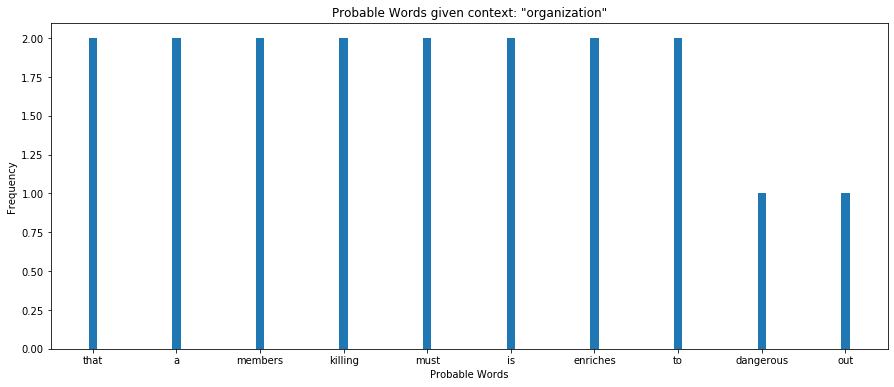

In [155]:
pws_2gram=probable_words('the world health organization', cpd_2gram, 2)
#probable words extraction givent context word

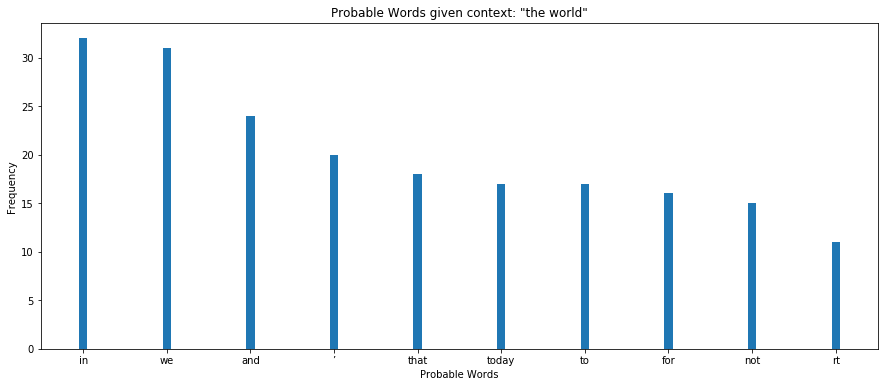

In [156]:
pws_3gram=probable_words('the world', cpd_3gram, 3)
#probable words with trigram model for context word "the world"

In [157]:
pws_3gram

[('in', 32),
 ('we', 31),
 ('and', 24),
 ('’', 20),
 ('that', 18),
 ('today', 17),
 ('to', 17),
 ('for', 16),
 ('not', 15),
 ('rt', 11),
 ('but', 10),
 ('it', 9)]

In [158]:
test_sent1='we are always there for you'
test_sent2='today that we met each other'

<h3> Obtaining probablity of the sentence with ngrams model</h3>

<p>With unigram you only need to pass Unigram probality distribution</p>

In [159]:
prob_1gram=find_sent_prob(test_sent2, cpd_1gram, ngram=1)
print(prob_1gram)

3.788798750955186e-17


<p>With Bigram you need to pass both unigram probality distribution and Bigram Probality distribution. It is necessary 
to assign the ngram parameter as <code>ngarm=2</code> for bigram and <code>ngarm=3</code> for trigram with the argument 
name, otherwise it will take default as <code>ngram=1</code>.</p> 

In [160]:
prob_2gram=find_sent_prob(test_sent1, cpd_1gram, cpd_2gram, ngram=2)
print(prob_2gram)

4.1694089436899207e-13


<p>With trigram you need to pass unigram probality distribution , Bigram Probality distribution and trigram 
probality distribution</p>

<h3>Model Evalution</h3>

In [161]:
entropy(cpd_1gram, test_corpus, 1)

0.0345849965882231

In [162]:
entropy(cpd_2gram, test_corpus, 2)

0.13120521494761928

In [163]:
entropy(cpd_3gram, test_corpus, 3)

0.10459973999814162

In [164]:
perplexity(cpd_1gram, test_corpus, 1)

1.0242621429961154

In [165]:
perplexity(cpd_2gram, test_corpus, 2)

1.0952082466938566

In [166]:
perplexity(cpd_3gram, test_corpus, 3)

1.0751960476583675

In [167]:
text_wiki=generate_txt_bigram_model(cpd_2gram, 'the', numwords=10)

In [168]:
text_wiki

'the us what i do we can help committee member and'

In [169]:
fd_1gram=ngram_freq_dist(train_corpus, ngram=1)
cpd_1gram_with_gt=nltk.SimpleGoodTuringProbDist(fd_1gram)   

In [170]:
vocab=len(fd_1gram)

In [171]:
cfd_2gram=ngram_freq_dist(train_corpus, ngram=2)
cpd_2gram_with_gt = nltk.ConditionalProbDist(cfd_2gram, nltk.SimpleGoodTuringProbDist, bins=pow(vocab,2))

In [172]:
cfd_3gram=ngram_freq_dist(train_corpus, ngram=3)
cpd_3gram_with_gt = nltk.ConditionalProbDist(cfd_3gram, nltk.SimpleGoodTuringProbDist, bins=pow(vocab,3))

In [173]:
cpd_3gram_with_gt[('donald', 'is')].freqdist()

FreqDist({'going': 1, 'for': 1})

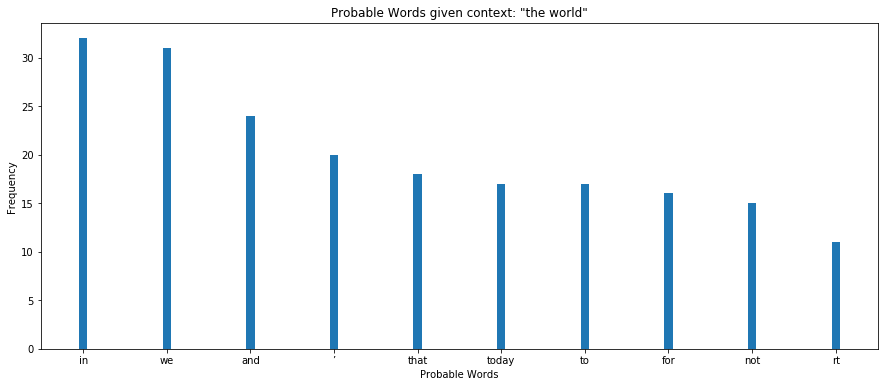

In [174]:
pws_3gram=probable_words('the world', cpd_3gram_with_gt, 3)

In [175]:
test_sent1='donald trump is going to be the president of us'
test_sent2='hillary clinton has no chance against him'

In [176]:
prob_1gram=find_sent_prob(test_sent2, cpd_1gram_with_gt)
print(prob_1gram)

1.5859337707327208e-21


In [177]:
prob_2gram=find_sent_prob(test_sent2, cpd_1gram_with_gt, cpd_2gram_with_gt, ngram=2)
print(prob_2gram)

7.602219612626636e-30


In [178]:
prob_3gram=find_sent_prob(test_sent1, cpd_1gram_with_gt, cpd_2gram_with_gt, cpd_3gram_with_gt, ngram=3)
print(prob_3gram)

9.242079129142584e-28


In [179]:
entropy(cpd_1gram_with_gt, test_corpus, 1)

0.03544762779687772

In [180]:
entropy(cpd_2gram_with_gt, test_corpus, 2)

0.12911700296835787

In [181]:
entropy(cpd_3gram_with_gt, test_corpus, 3)

0.10178577716111531

In [182]:
perplexity(cpd_1gram_with_gt, test_corpus, 1)

1.0248747635928688

In [183]:
perplexity(cpd_2gram_with_gt, test_corpus, 2)

1.0936241471101653

In [184]:
perplexity(cpd_3gram_with_gt, test_corpus, 3)

1.073100931997826

In [185]:
def ngram_freq_dist(corpus):
    freq_dist = freq_3gram = nltk.FreqDist(ngrams(corpus,3))
    return freq_dist

In [186]:
def trigram_prob(w1, w2, w3, prob_3gram):
    if prob_3gram is not None:
        #cprob_3gram=nltk.ConditionalProbDist(cfreq_3gram, nltk.MLEProbDist)
        prob=prob_3gram.prob((w1, w2, w3))
    else:
        print('Probablity distribution is not available')
    return prob

In [215]:
def entropy(pd, text):
    ngram=3
    test_corpus = text
    e = 0.0
    for i in range(ngram - 1, len(test_corpus)):
        context = test_corpus[i - ngram + 1:i]
        word = test_corpus[i]
        #print(str(context)+"    "+token)
        e += logprob(word, context, pd)
    return e / float(len(text) - (ngram - 1))

In [216]:
def logprob(word, context, pd):
    p=trigram_prob(context[0], context[1], word, pd)
    try:
        val=-p*log(p , 2)
    except ValueError:
        val=0.0
    return val

In [217]:
def perplexity(pd, text):
    test_corpus=text
    ent=entropy(pd, text)
    #print(ent)
    return pow(2.0, ent)

In [218]:
def find_sent_prob(sent, pd):
    total_prob=1
    for w1, w2, w3 in nltk.ngrams(nltk.word_tokenize(sent),3):
        #print(w1,w2,w3,trigram_prob(w1, w2, w3, pd))
        total_prob *= (trigram_prob(w1, w2, w3, pd))
    return total_prob

In [191]:
fd_3gram=ngram_freq_dist(train_corpus)
prob_3gram_kn=nltk.KneserNeyProbDist(fd_3gram) #probality distribution with Kneser ney smoothing

In [192]:
print(entropy(prob_3gram_kn, test_corpus))
print(perplexity(prob_3gram_kn, test_corpus))
print(find_sent_prob('the election is', prob_3gram_kn))

0.12819762092881873
1.092927438474139
0.014705882352941176


In [197]:
fd_1gram=ngram_freq_dist(train_corpus, ngram=1)
cpd_1gram_with_add1=nltk.LaplaceProbDist(fd_1gram) #Obtaining probality distribution with Add1 
#smoothing for unigram

In [198]:
vocab=len(fd_1gram) #vocabulary size

<h3>Obtaining conditional probality distribution with Add1 smoothing for Bigrams</h3>

In [199]:
cfd_2gram=ngram_freq_dist(train_corpus, ngram=2)
cpd_2gram_with_add1 = nltk.ConditionalProbDist(cfd_2gram, nltk.LaplaceProbDist, bins=pow(vocab,2))

In [200]:
#cpd_2gram_with_add1 = nltk.ConditionalProbDist(cfd_2gram, nltk.SimpleGoodTuringProbDist, bins=pow(vocab,2))

In [201]:
#dict(cpd_2gram_with_add1['azerbaijan'].freqdist())

<h3>Obtaining conditional probality distribution with Add1 smoothing for Trigrams</h3>

In [202]:
cfd_3gram=ngram_freq_dist(train_corpus, ngram=3)
cpd_3gram_with_add1 = nltk.ConditionalProbDist(cfd_3gram, nltk.LaplaceProbDist,bins=pow(vocab,3))

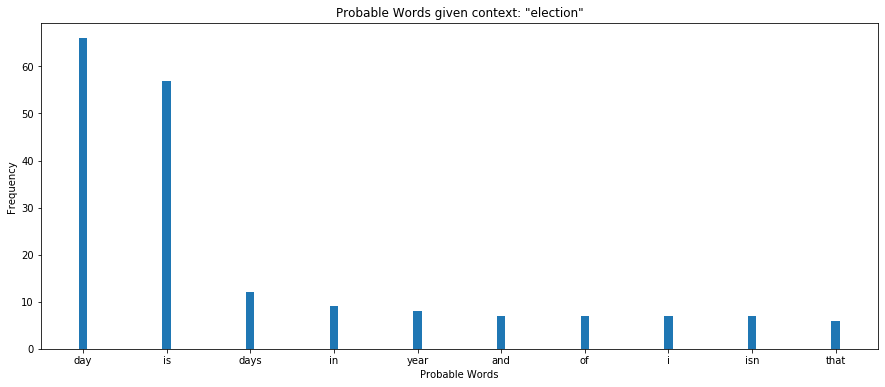

In [203]:
pws_2gram=probable_words('this election', cpd_2gram_with_add1, 2)

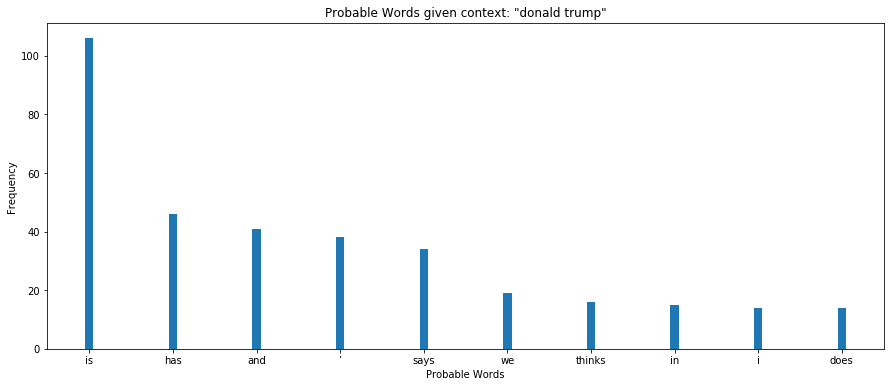

In [204]:
pws_3gram=probable_words('donald trump', cpd_3gram_with_add1, 3)

In [205]:
pws_3gram

[('is', 106),
 ('has', 46),
 ('and', 41),
 ('’', 38),
 ('says', 34),
 ('we', 19),
 ('thinks', 16),
 ('in', 15),
 ('i', 14),
 ('does', 14),
 ('just', 12),
 ('would', 12)]

In [206]:
test_sent1='iran has an embassy in baku'
test_sent2='iran embassy has an in baku'

In [207]:
prob_1gram=find_sent_prob(test_sent2, cpd_1gram_with_add1)
print(prob_1gram)

4.615872791148927e-24


In [210]:
prob_2gram=find_sent_prob(test_sent2,cpd_1gram_with_add1, cpd_2gram_with_add1, ngram=2)
print(prob_2gram)

7.673501276206689e-46


In [211]:
prob_3gram=find_sent_prob(test_sent1,cpd_1gram_with_add1, cpd_2gram_with_add1, cpd_3gram_with_add1, ngram=3)
print(prob_3gram)

1.0780764003263735e-64


In [223]:
entropy(cpd_1gram_with_add1, test_corpus, 1)

0.03377643415592588

In [224]:
entropy(cpd_2gram_with_add1, test_corpus, 2)

4.353086136137428e-06

In [225]:
entropy(cpd_3gram_with_add1, test_corpus, 3)

3.412765555323953e-11

In [226]:
perplexity(cpd_1gram_with_add1, test_corpus, 1)

1.0236882532746714

In [227]:
perplexity(cpd_2gram_with_add1, test_corpus, 2)

1.000003017333934

In [228]:
perplexity(cpd_3gram_with_add1, test_corpus, 3)

1.0000000000236555

*Kneser-Ney Smoothing</h

In [45]:
fd_3gram=ngram_freq_dist(train_corpus)
prob_3gram_kn=nltk.KneserNeyProbDist(fd_3gram) #probality distribution with Kneser ney smoothing

In [46]:
print(entropy(prob_3gram_kn, test_corpus))
print(perplexity(prob_3gram_kn, test_corpus))
print(find_sent_prob('the united nations',prob_3gram_kn))

0.06477206784606931
1.0459196813335965
0.10889175257731959
